In [1]:
import torch
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm
from src.model.regressor.regressor import LSTMRegressor
from src.model.discriminator.path_characteristic_function import pcf
from src.utils import AddTime
from torch.utils.data import DataLoader, Dataset
from src.datasets.fbm_ import FBM_data
from src.datasets.data_preparation import prepare_dl
from src.trainers.regression_trainer import regressor_joint_trainer
from src.high_level_pcf import high_order_pcf
import ml_collections
import seaborn as sns
import os
import yaml
from os import path as pt
os.environ["CUDA_VISIBLE_DEVICES"] = "4"
sns.set()
torch.manual_seed(0)
device = 'cuda'

In [2]:
config_dir = pt.join("configs/configs.yaml")
with open(config_dir) as file:
    config = ml_collections.ConfigDict(yaml.safe_load(file))

In [3]:
config.exp_dir = "./examples/HT/h_0.475/"

In [4]:
# Construct fbm path with different Hurst parameter

samples = 20000
steps = 50

bm = FBM_data(samples, dim=3, length=steps, h=0.5)
fbm_h = FBM_data(samples, dim=3, length=steps, h=0.475)

bm_test = FBM_data(4000, dim=3, length=steps, h=0.5)
fbm_h_test = FBM_data(4000, dim=3, length=steps, h=0.475)

fbm_h = fbm_h.to(device)
bm = bm.to(device)
fbm_h_test = fbm_h_test.to(device)
bm_test = bm_test.to(device)

In [5]:
torch.save(bm, config.exp_dir+'bm_train.pt')
torch.save(fbm_h, config.exp_dir+'fbm_train.pt')
torch.save(bm_test, config.exp_dir+'bm_test.pt')
torch.save(fbm_h_test, config.exp_dir+'fbm_test.pt')

In [4]:
fbm_h = torch.load(config.exp_dir+'fbm_train.pt')
bm = torch.load(config.exp_dir+'bm_train.pt')
fbm_h_test = torch.load(config.exp_dir+'fbm_test.pt')
bm_test = torch.load(config.exp_dir+'bm_test.pt')

In [5]:
config.R_input_dim = bm.shape[-1]+1 # Add time
config.data_feat_dim = bm.shape[-1]
config.n_lags = bm.shape[2]

rank_1_pcf = pcf(num_samples=config.Rank_1_num_samples,
                 hidden_size=config.Rank_1_lie_degree,
                 input_dim=bm.shape[-1],
                 add_time=True,
                 include_initial=False
                 ).to(config.device)

In [6]:
train_reg_X_dl, test_reg_X_dl, train_pcf_X_dl, test_pcf_X_dl = prepare_dl(config, rank_1_pcf, bm, bm_test)
train_reg_Y_dl, test_reg_Y_dl, train_pcf_Y_dl, test_pcf_Y_dl = prepare_dl(config, rank_1_pcf, fbm_h, fbm_h_test)

51
51


In [7]:
regressor_for_X = LSTMRegressor(
        input_dim=config.R_input_dim,
        hidden_dim=config.R_hidden_dim,
        output_dim=config.R_output_dim,
        n_layers=config.R_num_layers
    )
regressor_for_X.to(device)

regressor_for_Y = LSTMRegressor(
        input_dim=config.R_input_dim,
        hidden_dim=config.R_hidden_dim,
        output_dim=config.R_output_dim,
        n_layers=config.R_num_layers
    )
regressor_for_Y.to(device)

regressor_for_Y.load_state_dict(regressor_for_X.state_dict())

<All keys matched successfully>

In [8]:
regressor_trainer = regressor_joint_trainer(regressor_for_X, regressor_for_Y, config, device)

In [9]:
trained_regressor_X, trained_regressor_Y, loss = regressor_trainer.joint_training(train_reg_X_dl, test_reg_X_dl, train_reg_Y_dl, test_reg_Y_dl)

  0%|                                                                                                                                                                                                                  | 1/2000 [00:00<05:33,  6.00it/s]

Loss updated: 142.33755493164062  at iteration 0
Loss updated: 142.17147827148438  at iteration 0
Loss updated: 133.28427124023438  at iteration 1
Loss updated: 133.87399291992188  at iteration 1


  0%|▍                                                                                                                                                                                                                 | 4/2000 [00:00<02:16, 14.61it/s]

Loss updated: 127.62334442138672  at iteration 2
Loss updated: 127.22502136230469  at iteration 2
Loss updated: 122.34477996826172  at iteration 3
Loss updated: 122.56559753417969  at iteration 3
Loss updated: 118.57646179199219  at iteration 4
Loss updated: 118.9749755859375  at iteration 4
Loss updated: 115.57603454589844  at iteration 5
Loss updated: 116.17765808105469  at iteration 5
Loss updated: 113.29983520507812  at iteration 6
Loss updated: 113.51187133789062  at iteration 6


  0%|█                                                                                                                                                                                                                | 10/2000 [00:00<01:42, 19.46it/s]

Loss updated: 111.20858764648438  at iteration 7
Loss updated: 111.66319274902344  at iteration 7
Loss updated: 110.31678771972656  at iteration 8
Loss updated: 110.92900085449219  at iteration 8
Loss updated: 109.65437316894531  at iteration 9
Loss updated: 109.97898864746094  at iteration 9
Loss updated: 109.21884155273438  at iteration 10
Loss updated: 109.76739501953125  at iteration 10
Loss updated: 108.41443634033203  at iteration 11
Loss updated: 108.8815689086914  at iteration 11


  1%|█▋                                                                                                                                                                                                               | 16/2000 [00:00<01:35, 20.88it/s]

Loss updated: 108.0533447265625  at iteration 12
Loss updated: 107.81916046142578  at iteration 13
Loss updated: 107.90325164794922  at iteration 13
Loss updated: 107.31072998046875  at iteration 14
Loss updated: 107.10047149658203  at iteration 15
Loss updated: 107.67633056640625  at iteration 15
Loss updated: 106.85271453857422  at iteration 16


  1%|█▉                                                                                                                                                                                                               | 19/2000 [00:00<01:33, 21.22it/s]

Loss updated: 106.9912109375  at iteration 16
Loss updated: 106.552978515625  at iteration 17
Loss updated: 106.53633880615234  at iteration 19
Loss updated: 106.79138946533203  at iteration 19
Loss updated: 106.07498168945312  at iteration 20


  1%|██▌                                                                                                                                                                                                              | 25/2000 [00:01<01:31, 21.60it/s]

Loss updated: 105.63072204589844  at iteration 21
Loss updated: 105.54417419433594  at iteration 22
Loss updated: 106.7108383178711  at iteration 23
Loss updated: 105.235595703125  at iteration 24
Loss updated: 106.38693237304688  at iteration 24
Loss updated: 106.07235717773438  at iteration 25


  1%|██▉                                                                                                                                                                                                              | 28/2000 [00:01<01:30, 21.84it/s]

Loss updated: 106.05110168457031  at iteration 26
Loss updated: 104.9109115600586  at iteration 27
Loss updated: 105.94951629638672  at iteration 27
Loss updated: 105.86367797851562  at iteration 28


  2%|███▏                                                                                                                                                                                                             | 31/2000 [00:01<01:47, 18.29it/s]

Loss updated: 104.60630798339844  at iteration 29
Loss updated: 105.55574798583984  at iteration 29
Loss updated: 104.17196655273438  at iteration 31
Loss updated: 105.28916931152344  at iteration 31
Loss updated: 104.08595275878906  at iteration 33
Loss updated: 105.28424072265625  at iteration 33


  2%|███▊                                                                                                                                                                                                             | 37/2000 [00:01<01:38, 20.02it/s]

Loss updated: 104.99824523925781  at iteration 34
Loss updated: 104.98739624023438  at iteration 35
Loss updated: 103.92106628417969  at iteration 36
Loss updated: 104.87843322753906  at iteration 37
Loss updated: 104.8763198852539  at iteration 38


  2%|████▍                                                                                                                                                                                                            | 43/2000 [00:02<01:32, 21.06it/s]

Loss updated: 104.60484313964844  at iteration 39
Loss updated: 104.23908996582031  at iteration 40
Loss updated: 103.1710433959961  at iteration 42
Loss updated: 104.2052230834961  at iteration 42
Loss updated: 104.19815063476562  at iteration 43


  2%|████▊                                                                                                                                                                                                            | 46/2000 [00:02<01:31, 21.43it/s]

Loss updated: 103.06039428710938  at iteration 44
Loss updated: 103.05891418457031  at iteration 45
Loss updated: 104.0634765625  at iteration 45
Loss updated: 102.84674072265625  at iteration 46
Loss updated: 102.65850830078125  at iteration 47


  3%|█████▍                                                                                                                                                                                                           | 52/2000 [00:02<01:32, 21.04it/s]

Loss updated: 103.9385757446289  at iteration 49


  3%|█████▋                                                                                                                                                                                                           | 55/2000 [00:02<01:44, 18.58it/s]

Loss updated: 103.81798553466797  at iteration 52
Loss updated: 103.30770874023438  at iteration 53


  3%|██████▌                                                                                                                                                                                                          | 63/2000 [00:03<01:36, 20.09it/s]

Loss updated: 102.60420227050781  at iteration 60


  3%|███████▏                                                                                                                                                                                                         | 69/2000 [00:03<01:31, 21.12it/s]

Loss updated: 102.27447509765625  at iteration 66


  4%|███████▊                                                                                                                                                                                                         | 75/2000 [00:03<01:29, 21.59it/s]

Loss updated: 103.27115631103516  at iteration 71
Loss updated: 101.97210693359375  at iteration 73
Loss updated: 103.17910766601562  at iteration 73


  4%|████████▏                                                                                                                                                                                                        | 78/2000 [00:03<01:41, 18.93it/s]

Loss updated: 101.72554016113281  at iteration 76
Loss updated: 102.96646118164062  at iteration 76


  4%|█████████                                                                                                                                                                                                        | 87/2000 [00:04<01:31, 20.97it/s]

Loss updated: 102.67733001708984  at iteration 83


  5%|██████████▌                                                                                                                                                                                                     | 102/2000 [00:05<01:42, 18.53it/s]

Loss updated: 102.59561920166016  at iteration 99
Loss updated: 102.49951171875  at iteration 101


  5%|███████████▏                                                                                                                                                                                                    | 108/2000 [00:05<01:33, 20.19it/s]

Loss updated: 102.32455444335938  at iteration 105
Loss updated: 101.6160888671875  at iteration 107


  6%|███████████▊                                                                                                                                                                                                    | 114/2000 [00:05<01:29, 21.13it/s]

Loss updated: 101.34153747558594  at iteration 112


  7%|█████████████▋                                                                                                                                                                                                  | 132/2000 [00:06<01:30, 20.55it/s]

Loss updated: 102.21269226074219  at iteration 127
Loss updated: 101.3069839477539  at iteration 130


  7%|██████████████                                                                                                                                                                                                  | 135/2000 [00:06<01:28, 20.97it/s]

Loss updated: 101.23221588134766  at iteration 132


  7%|██████████████▉                                                                                                                                                                                                 | 144/2000 [00:07<01:25, 21.61it/s]

Loss updated: 101.9874038696289  at iteration 141


  8%|████████████████▋                                                                                                                                                                                               | 161/2000 [00:07<01:28, 20.90it/s]

Loss updated: 101.97914123535156  at iteration 157
Loss updated: 101.97428894042969  at iteration 158


  8%|█████████████████▋                                                                                                                                                                                              | 170/2000 [00:08<01:24, 21.63it/s]

Loss updated: 101.88398742675781  at iteration 165
Loss updated: 101.16999816894531  at iteration 166


  9%|██████████████████▌                                                                                                                                                                                             | 179/2000 [00:08<01:30, 20.14it/s]

Loss updated: 101.69559478759766  at iteration 177
Loss updated: 101.06904602050781  at iteration 178


 10%|████████████████████▊                                                                                                                                                                                           | 200/2000 [00:09<01:31, 19.65it/s]

Loss updated: 100.7999496459961  at iteration 198


 12%|█████████████████████████▍                                                                                                                                                                                      | 245/2000 [00:12<01:28, 19.91it/s]

Loss updated: 100.67638397216797  at iteration 242


 13%|██████████████████████████                                                                                                                                                                                      | 251/2000 [00:12<01:26, 20.20it/s]

Loss updated: 101.28172302246094  at iteration 249


 13%|██████████████████████████▋                                                                                                                                                                                     | 257/2000 [00:12<01:22, 21.09it/s]

Loss updated: 100.3356704711914  at iteration 254


 28%|█████████████████████████████████████████████████████████▌                                                                                                                                                      | 554/2000 [00:27<01:11, 20.25it/s]

Loss updated: 101.15760803222656  at iteration 551


 32%|█████████████████████████████████████████████████████████████████▋                                                                                                                                              | 632/2000 [00:30<01:03, 21.54it/s]

Loss updated: 100.23651123046875  at iteration 628


 33%|████████████████████████████████████████████████████████████████████▏                                                                                                                                           | 656/2000 [00:31<01:04, 20.81it/s]

Loss updated: 100.17915344238281  at iteration 654


 34%|██████████████████████████████████████████████████████████████████████                                                                                                                                          | 674/2000 [00:32<01:03, 20.93it/s]

Loss updated: 101.08171081542969  at iteration 671


 45%|█████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                                                  | 896/2000 [00:43<00:47, 23.22it/s]

Loss updated: 100.17501831054688  at iteration 894


 49%|██████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                                         | 989/2000 [00:47<00:43, 23.33it/s]

Loss updated: 101.02668762207031  at iteration 986


 57%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                         | 1136/2000 [00:54<00:41, 20.65it/s]

Loss updated: 100.13642883300781  at iteration 1133


 64%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                          | 1286/2000 [01:00<00:31, 22.37it/s]

Loss updated: 100.09407043457031  at iteration 1282


 82%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                     | 1637/2000 [01:16<00:16, 21.54it/s]

Loss updated: 100.98931121826172  at iteration 1633


 86%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                             | 1718/2000 [01:20<00:12, 22.78it/s]

Loss updated: 100.938232421875  at iteration 1714


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2000/2000 [01:33<00:00, 21.40it/s]


In [21]:
config.Rank_2_num_samples = 10

In [23]:
rank_2_pcf = high_order_pcf(regressor_X = trained_regressor_X, 
                           lie_degree_1 = config.Rank_1_lie_degree, 
                           lie_degree_2 = config.Rank_2_lie_degree,  
                           num_samples_2 = config.Rank_2_num_samples, 
                           config = config, 
                           whole_dev = True, 
                           regressor_Y = trained_regressor_Y, 
                           add_time=True, 
                           device=config.device)

In [24]:
losses = rank_2_pcf.train_M(train_pcf_X_dl, train_pcf_Y_dl, test_pcf_X_dl, test_pcf_Y_dl, 500)

start opitmize charateristics function


  0%|                                                                                                                                                                                                                           | 0/500 [00:00<?, ?it/s]

Loss updated: 0.01530449092388153
Iteration 0 :  loss = 0.01530449092388153


  0%|▊                                                                                                                                                                                                                  | 2/500 [00:01<05:14,  1.58it/s]

Loss updated: 0.01726624369621277


  4%|█████████▏                                                                                                                                                                                                        | 22/500 [00:12<04:25,  1.80it/s]

Loss updated: 0.017961522564291954


  5%|█████████▋                                                                                                                                                                                                        | 23/500 [00:12<04:08,  1.92it/s]

Loss updated: 0.017995942384004593


  6%|███████████▊                                                                                                                                                                                                      | 28/500 [00:15<04:05,  1.92it/s]

Loss updated: 0.018177643418312073


  6%|████████████▏                                                                                                                                                                                                     | 29/500 [00:15<04:30,  1.74it/s]

Loss updated: 0.0184920784085989


  6%|████████████▌                                                                                                                                                                                                     | 30/500 [00:16<04:15,  1.84it/s]

Loss updated: 0.018941016867756844


  6%|█████████████▍                                                                                                                                                                                                    | 32/500 [00:17<04:35,  1.70it/s]

Loss updated: 0.019778219982981682


  7%|██████████████▎                                                                                                                                                                                                   | 34/500 [00:18<03:58,  1.96it/s]

Loss updated: 0.020337386056780815


  7%|██████████████▋                                                                                                                                                                                                   | 35/500 [00:18<03:47,  2.04it/s]

Loss updated: 0.020408907905220985


  7%|███████████████▌                                                                                                                                                                                                  | 37/500 [00:20<04:20,  1.78it/s]

Loss updated: 0.022032490000128746


  8%|███████████████▉                                                                                                                                                                                                  | 38/500 [00:20<04:02,  1.90it/s]

Loss updated: 0.02247592620551586


 10%|█████████████████████▊                                                                                                                                                                                            | 52/500 [00:28<04:09,  1.79it/s]

Loss updated: 0.02298695407807827


 11%|██████████████████████▎                                                                                                                                                                                           | 53/500 [00:28<03:53,  1.91it/s]

Loss updated: 0.023739613592624664


 11%|██████████████████████▋                                                                                                                                                                                           | 54/500 [00:29<03:42,  2.01it/s]

Loss updated: 0.023756632581353188


 12%|█████████████████████████▏                                                                                                                                                                                        | 60/500 [00:32<03:30,  2.09it/s]

Loss updated: 0.023914208635687828


 12%|██████████████████████████                                                                                                                                                                                        | 62/500 [00:33<04:03,  1.80it/s]

Loss updated: 0.02465166710317135


 13%|███████████████████████████▎                                                                                                                                                                                      | 65/500 [00:35<03:27,  2.09it/s]

Loss updated: 0.02557443454861641


 13%|███████████████████████████▋                                                                                                                                                                                      | 66/500 [00:35<04:24,  1.64it/s]

Loss updated: 0.026385022327303886


 14%|████████████████████████████▉                                                                                                                                                                                     | 69/500 [00:37<03:40,  1.96it/s]

Loss updated: 0.026813512668013573


 15%|██████████████████████████████▋                                                                                                                                                                                   | 73/500 [00:39<03:44,  1.90it/s]

Loss updated: 0.02723311260342598


 16%|█████████████████████████████████▏                                                                                                                                                                                | 79/500 [00:42<03:56,  1.78it/s]

Loss updated: 0.027527112513780594


 16%|█████████████████████████████████▌                                                                                                                                                                                | 80/500 [00:43<03:45,  1.87it/s]

Loss updated: 0.029330400750041008


 16%|██████████████████████████████████                                                                                                                                                                                | 81/500 [00:44<04:34,  1.53it/s]

Loss updated: 0.02953050099313259


 17%|████████████████████████████████████                                                                                                                                                                              | 86/500 [00:47<04:20,  1.59it/s]

Loss updated: 0.03159263730049133


 20%|█████████████████████████████████████████▊                                                                                                                                                                       | 100/500 [00:54<03:13,  2.07it/s]

Loss updated: 0.031877338886260986
Iteration 100 :  loss = 0.031877338886260986


 20%|██████████████████████████████████████████▋                                                                                                                                                                      | 102/500 [00:55<03:43,  1.78it/s]

Loss updated: 0.03218436986207962


 21%|███████████████████████████████████████████                                                                                                                                                                      | 103/500 [00:56<03:28,  1.90it/s]

Loss updated: 0.03273819014430046


 21%|████████████████████████████████████████████▋                                                                                                                                                                    | 107/500 [00:58<03:41,  1.77it/s]

Loss updated: 0.03369786962866783


 22%|█████████████████████████████████████████████▌                                                                                                                                                                   | 109/500 [00:59<03:16,  1.99it/s]

Loss updated: 0.03435031324625015


 22%|█████████████████████████████████████████████▉                                                                                                                                                                   | 110/500 [00:59<03:09,  2.06it/s]

Loss updated: 0.034672193229198456


 22%|██████████████████████████████████████████████▍                                                                                                                                                                  | 111/500 [01:00<03:59,  1.62it/s]

Loss updated: 0.0360664501786232


 24%|█████████████████████████████████████████████████▋                                                                                                                                                               | 119/500 [01:04<03:17,  1.93it/s]

Loss updated: 0.036100734025239944


 24%|██████████████████████████████████████████████████▉                                                                                                                                                              | 122/500 [01:06<03:35,  1.76it/s]

Loss updated: 0.037047628313302994


 27%|████████████████████████████████████████████████████████▊                                                                                                                                                        | 136/500 [01:14<03:46,  1.61it/s]

Loss updated: 0.03711819276213646


 28%|█████████████████████████████████████████████████████████▋                                                                                                                                                       | 138/500 [01:15<03:12,  1.88it/s]

Loss updated: 0.03911107778549194


 28%|██████████████████████████████████████████████████████████                                                                                                                                                       | 139/500 [01:15<03:02,  1.98it/s]

Loss updated: 0.04007015749812126


 29%|████████████████████████████████████████████████████████████▌                                                                                                                                                    | 145/500 [01:18<02:55,  2.02it/s]

Loss updated: 0.04024649038910866


 30%|█████████████████████████████████████████████████████████████▊                                                                                                                                                   | 148/500 [01:20<03:07,  1.87it/s]

Loss updated: 0.040454037487506866


 30%|███████████████████████████████████████████████████████████████▌                                                                                                                                                 | 152/500 [01:22<03:17,  1.77it/s]

Loss updated: 0.04339195415377617


 35%|████████████████████████████████████████████████████████████████████████▎                                                                                                                                        | 173/500 [01:34<02:54,  1.87it/s]

Loss updated: 0.04372536763548851


 36%|██████████████████████████████████████████████████████████████████████████▍                                                                                                                                      | 178/500 [01:37<03:18,  1.62it/s]

Loss updated: 0.0441662073135376


 36%|██████████████████████████████████████████████████████████████████████████▊                                                                                                                                      | 179/500 [01:37<03:04,  1.74it/s]

Loss updated: 0.04448525235056877


 36%|████████████████████████████████████████████████████████████████████████████                                                                                                                                     | 182/500 [01:39<03:07,  1.69it/s]

Loss updated: 0.045303672552108765


 37%|████████████████████████████████████████████████████████████████████████████▉                                                                                                                                    | 184/500 [01:40<02:43,  1.93it/s]

Loss updated: 0.04628916457295418


 38%|███████████████████████████████████████████████████████████████████████████████▍                                                                                                                                 | 190/500 [01:43<02:31,  2.04it/s]

Loss updated: 0.047144580632448196


 40%|███████████████████████████████████████████████████████████████████████████████████▌                                                                                                                             | 200/500 [01:49<02:26,  2.04it/s]

Iteration 200 :  loss = 0.04486442357301712


 40%|████████████████████████████████████████████████████████████████████████████████████                                                                                                                             | 201/500 [01:50<03:05,  1.61it/s]

Loss updated: 0.04789295047521591


 42%|███████████████████████████████████████████████████████████████████████████████████████▎                                                                                                                         | 209/500 [01:54<02:27,  1.98it/s]

Loss updated: 0.0490531399846077


 44%|███████████████████████████████████████████████████████████████████████████████████████████                                                                                                                      | 218/500 [01:59<02:33,  1.84it/s]

Loss updated: 0.05000585317611694


 47%|██████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                                                              | 236/500 [02:09<02:42,  1.62it/s]

Loss updated: 0.050377439707517624


 50%|████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                                                        | 251/500 [02:17<02:34,  1.61it/s]

Loss updated: 0.05344628915190697


 57%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                          | 283/500 [02:34<01:55,  1.87it/s]

Loss updated: 0.053571563214063644


 59%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                                      | 294/500 [02:40<01:46,  1.94it/s]

Loss updated: 0.053582143038511276


 60%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                   | 300/500 [02:43<01:38,  2.04it/s]

Iteration 300 :  loss = 0.052031099796295166


 62%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                                | 308/500 [02:48<01:42,  1.87it/s]

Loss updated: 0.05422762781381607


 62%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                              | 312/500 [02:50<01:47,  1.75it/s]

Loss updated: 0.05470171198248863


 65%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                          | 323/500 [02:56<01:36,  1.83it/s]

Loss updated: 0.05595941096544266


 70%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                               | 349/500 [03:10<01:16,  1.96it/s]

Loss updated: 0.05639054253697395


 73%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                        | 366/500 [03:20<01:23,  1.61it/s]

Loss updated: 0.057217467576265335


 77%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                 | 383/500 [03:29<01:02,  1.87it/s]

Loss updated: 0.05732689052820206


 77%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                               | 387/500 [03:31<01:04,  1.75it/s]

Loss updated: 0.06009180471301079


 80%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                         | 400/500 [03:38<00:49,  2.03it/s]

Iteration 400 :  loss = 0.05851154401898384


 83%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                    | 414/500 [03:46<00:43,  1.97it/s]

Loss updated: 0.06089865788817406


 85%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                              | 427/500 [03:53<00:41,  1.75it/s]

Loss updated: 0.062290143221616745


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 500/500 [04:33<00:00,  1.83it/s]


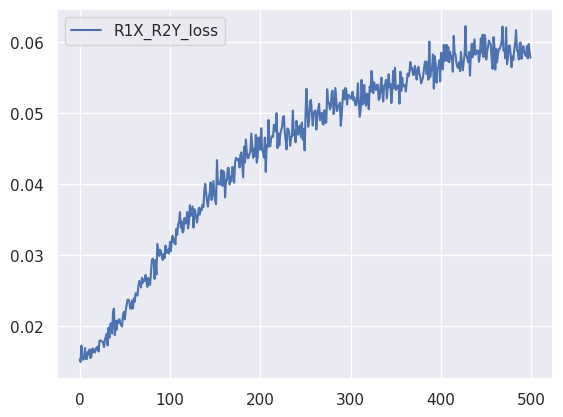

In [25]:
plt.plot(losses['R1X_R2Y_loss'], label = "R1X_R2Y_loss")
plt.legend()
plt.show()

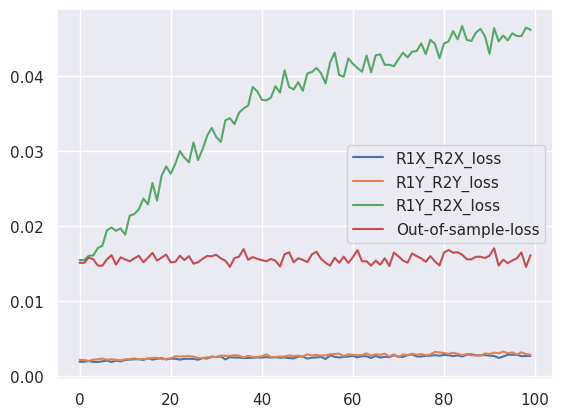

In [26]:
plt.plot(losses['R1X_R2X_loss'], label = "R1X_R2X_loss")
plt.plot(losses['R1Y_R2Y_loss'], label = "R1Y_R2Y_loss")
plt.plot(losses['R1Y_R2X_loss'], label = "R1Y_R2X_loss")
plt.plot(losses['Out-of-sample-loss'], label = "Out-of-sample-loss")
plt.legend()
plt.show()

In [27]:
power, type1_error, H0_stats, H1_stats = rank_2_pcf.permutation_test(test_pcf_X_dl.dataset, 
                                                                    test_pcf_Y_dl.dataset, 
                                                                    sample_size = 200, 
                                                                    num_permutations=500)

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 500/500 [00:31<00:00, 15.64it/s]


In [28]:
power

0.31399999999999995